In [313]:
# --------------------------------------------------
# TREC IS 2019 Evaluation Script
# Configured for 2019-A Events
# Used to evaluate TREC-IS runs
# --------------------------------------------------
version = 2.0 # Notebook Version Number

# Configuration (Change this to match your setting)
# System output file to evaluate:
runFile = "Random_forest_no_shuffle.run"
runName = "myrun"

# The location of the ground truth data against which to compare the run
classificationLabelFiles = [
    "2019A-assr1.json",
    "2019A-assr2.json",
    "2019A-assr3.json",
    "2019A-assr4.json",
    "2019A-assr5.json",
    "2019A-assr6.json",
    "2019-assr2.json"
]

# The location of the ontology file
ontologyFile = "ITR-H.types.v3.json"

# --------------------------------------------------
# Static data for the 2019 edition
# --------------------------------------------------
# Identifiers for the test events
eventIdentifiers = [
    "floodChoco2019",
    "earthquakeCalifornia2014",
    "earthquakeBohol2013",
    "hurricaneFlorence2018",
    "shootingDallas2017",
    "fireYMM2016"
]

# Mapping of prority labels (by assessors) into numerical values [0-1]
# We use this to calculate error against the participant priority scores
priorityMapping = {
    "Critical" : 1.0,
    "High" : 0.75,
    "Medium" : 0.5,
    "Low" : 0.25
}

# What we consider to be highly important categories of information
highImportCategories = [
    "Request-GoodsServices",
    "Request-SearchAndRescue",
    "CallToAction-MovePeople",
    "Report-EmergingThreats",
    "Report-NewSubEvent",
    "Report-ServiceAvailable"
]

highImportCategoriesShort = [
    "GoodsServices",
    "SearchAndRescue",
    "MovePeople",
    "EmergingThreats",
    "NewSubEvent",
    "ServiceAvailable"
]

# Parameters
var_lambda = 0.75 # weight to place on actionable information categories in comparison to non actionable categoriee
var_alpha = 0.3 # Flat gain for providing a correct alert, regardless of the categories selected
alertPriorityThreshold = 0.7

resultsFile = open(runName+".results.overall.txt","w+")
resultsFile.write("TREC-IS 2019-A Notebook Evaluator v"+str(version)+"\n")
resultsFile.write("Run: "+runName+" ("+runFile+")"+"\n")
resultsFile.write(""+"\n")

perTopicFile = open(runName+".results.pertopic.txt","w+")
perTopicFile.write("TREC-IS 2019-A Notebook Evaluator v"+str(version)+"\n")
perTopicFile.write("Run: "+runName+" ("+runFile+")"+"\n")
perTopicFile.write(""+"\n")

perEventFile = open(runName+".results.perevent.txt","w+")
perEventFile.write("TREC-IS 2019-A Notebook Evaluator v"+str(version)+"\n")
perEventFile.write("Run: "+runName+" ("+runFile+")"+"\n")
perEventFile.write(""+"\n")


# --------------------------------------------------
# Processing Starts Here
# --------------------------------------------------
import json
from pprint import pprint
import gzip
import math
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

# --------------------------------------------------
# Stage 1: Load the ground truth dataset 
# --------------------------------------------------

groundtruthJSON = []
for groundtruthFile in classificationLabelFiles:
    print("Reading "+groundtruthFile)
    with open(groundtruthFile, encoding='latin-1') as groundtruthJSONFile:    
        groundtruthJSON.append(json.load(groundtruthJSONFile))
#pprint(groundtruthJSON["events"])

# --------------------------------------------------
# Stage 2: Load run file 
# --------------------------------------------------
with open(runFile, encoding='utf-8') as openRunFile:
    runContents = openRunFile.readlines() # lines not yet decoded
#pprint(runContents[0])

# --------------------------------------------------
# Stage 3: Load the categories 
# --------------------------------------------------
with open(ontologyFile, encoding='utf-8') as ontologyJSONFile:    
    ontologyJSON = json.load(ontologyJSONFile)

informationTypes2Index = {} # category -> numerical index
informationTypesShort2Index = {} # category short form (e.g. Report-EmergingThreats vs. EmergingThreats) -> numerical index
informationTypeIndex = 0
for informationTypeJSON in ontologyJSON["informationTypes"]:
    informationTypeId = informationTypeJSON["id"]
    informationTypes2Index[informationTypeId] = informationTypeIndex
    informationTypesShort2Index[informationTypeId.split("-")[1]] = informationTypeIndex
    informationTypeIndex = informationTypeIndex + 1
    
# -----------------------------------------------------------
# Stage 4: Produce ground truth maps between tweetIds and categories
# -----------------------------------------------------------
# Notes: Ground truth is used as a base, if a run includes tweets
#        not in the ground truth they will be ignored
# Assumptions: A tweet will not be returned for multiple events

tweetId2TRECInfoCategories = {} # tweet id -> Array of categories selected by assessors
tweetId2TRECHighImportInfoCategories = {} # tweet id -> Array of categories selected by assessors
tweetId2TRECLowImportInfoCategories = {} # tweet id -> Array of categories selected by assessors
tweetId2TRECPriorityCategory = {} # tweet id -> priority label (Critical,High,Medium,Low)
index2TweetId = {} # ordered tweets
event2tweetIds = {} # event -> tweet ids for tweets within that event
countHighCriticalImport = 0
countLowMediumImport = 0

tweetIndex = 0
for groundtruth in groundtruthJSON:
    for eventJSON in groundtruth["events"]:
        eventid = eventJSON["eventid"]
        #print(eventid)
        # two events were split and assessed in parts, re-name these so they are correctly read
        if eventid.endswith("A") | eventid.endswith("B") | eventid.endswith("C") | eventid.endswith("D") | eventid.endswith("E"):
            eventid = eventid[:-1]
        
        if not event2tweetIds.get(eventid):
            event2tweetIds[eventid] = []
        
        if any(eventid in s for s in eventIdentifiers):
            # iterate over tweets in the event
            for tweetJSON in eventJSON["tweets"]:
                tweetid = tweetJSON["postID"]
                categories = tweetJSON["categories"]
                priority = tweetJSON["priority"]
                
                if priority == "High" or priority == "Critical":
                    countHighCriticalImport = countHighCriticalImport + 1
                
                if priority == "Low" or priority == "Medium":
                    countLowMediumImport = countLowMediumImport + 1
                
                event2tweetIds[eventid].append(tweetid)
                
                # check categories for name issues and correct if possible
                cleanedCategories = []
                highImportCats = []
                lowImportCats = []
                for categoryId in categories:
                    if not any(categoryId in s for s in informationTypesShort2Index.keys()):
                        print("Found unknown category "+categoryId)
                    else:
                        cleanedCategories.append(categoryId)
                        if any(categoryId in s for s in highImportCategoriesShort):
                            highImportCats.append(categoryId)
                        else:
                            lowImportCats.append(categoryId)
    
                tweetId2TRECInfoCategories[tweetid] = cleanedCategories
                tweetId2TRECHighImportInfoCategories[tweetid] = highImportCats
                tweetId2TRECLowImportInfoCategories[tweetid] = lowImportCats
                tweetId2TRECPriorityCategory[tweetid] = priority
                index2TweetId[tweetIndex] = tweetid;
                tweetIndex = tweetIndex + 1

                
        else:
            print("WARN: Found ground truth data for event not in the 2019 topic set "+eventid+", ignoring...")
        
# -----------------------------------------------------------
# Stage 5: Produce run predicted maps between tweetIds and categories
# -----------------------------------------------------------
tweetId2RunInfoCategories = {} # tweet id -> predicted category by participant system
tweetId2RunHighImportInfoCategories = {} # tweet id -> predicted category by participant system
tweetId2RunLowImportInfoCategories = {} # tweet id -> predicted category by participant system
tweetId2RunPriorityScore = {} # tweet id -> importance score from participant system
tweetId2RunPriorityScoreNorm = {} # tweet id -> importance score from participant system
event2TweetIdRank = {} # event -> (rank,tweetid)

maxPrediction = -999999
minPrediction = 999999

for runLine in runContents:
    predictionParts = runLine.strip().replace(", ", ",").replace("\",\" ", "\",\"").replace(" ","\t").replace("'","\"").split('\t')
    
    #print(runLine)
    if (len(predictionParts)<6 ):
        continue
    else:
        eventId = predictionParts[0]
        tweetId = predictionParts[2]
        rank = float(predictionParts[3])
        #print(predictionParts[5])
        categories = json.loads(predictionParts[5])
        priority = predictionParts[4]
        
        priorityNum = float(priority)
        if (maxPrediction<priorityNum): 
            maxPrediction = priorityNum
        if (minPrediction>priorityNum):
            minPrediction = priorityNum
        
        tweetId2RunInfoCategories[tweetId] = categories
        tweetId2RunPriorityScore[tweetId] = priority
        
        if not event2TweetIdRank.get(eventId):
            event2TweetIdRank[eventId] = []
        rankTuple = (tweetId,rank)
        event2TweetIdRank.get(eventId).append(rankTuple)
        
        highImportCats = []
        lowImportCats = []
        for categoryId in categories:
            cleanedCategories.append(categoryId)
            if any(categoryId in s for s in highImportCategories):
                highImportCats.append(categoryId)
            else:
                lowImportCats.append(categoryId)
                
        tweetId2RunHighImportInfoCategories[tweetId] = highImportCats
        tweetId2RunLowImportInfoCategories[tweetId] = lowImportCats

for eventId in event2TweetIdRank.keys():
    tweetsSorted = sorted(event2TweetIdRank.get(eventId), key=lambda tup: tup[1])
    event2TweetIdRank[eventId] = tweetsSorted
    
for i in range(len(index2TweetId)):
    tweetId = index2TweetId[i]
    if tweetId2RunPriorityScore.get(tweetId):
        
        priority = float(tweetId2RunPriorityScore.get(tweetId))
                
        # scale to between 0 and 1
        if (maxPrediction-minPrediction)>0:
            tweetId2RunPriorityScoreNorm[tweetId] = (priority-minPrediction)/(maxPrediction-minPrediction)
        else:
            tweetId2RunPriorityScoreNorm[tweetId] = 0.0
    else:
        tweetId2RunPriorityScoreNorm[tweetId] = 0.0
    
# --------------------------------------------------
# Stage 6: Create ground truth vectors per category
# --------------------------------------------------

category2GroundTruth = {} # category -> tweet vector with binary 1 vs all ground truth category labels

for categoryId in informationTypes2Index.keys():
    categoryIdShort = categoryId.split("-")[1]
    categoryVector = []
    for i in range(len(index2TweetId)):
        tweetId = index2TweetId[i]
        categories = tweetId2TRECInfoCategories.get(tweetId)
        #pprint(categories)
        if any(categoryIdShort in s for s in categories):
            categoryVector.append(1)
        else:
            categoryVector.append(0)
    category2GroundTruth[categoryId] = categoryVector
            
#pprint(category2GroundTruth)

# --------------------------------------------------
# Stage 7: Create run vectors per category 
# --------------------------------------------------
# Assumptions: If run misses a tweet, we assume id has
#              no categories
category2Predicted = {} # category -> tweet vector with binary 1 vs all predicted by system labels

for categoryId in informationTypes2Index.keys():
    categoryIdShort = categoryId.split("-")[1]
    categoryVector = []
    for i in range(len(index2TweetId)):
        tweetId = index2TweetId[i]
        
        if tweetId2RunInfoCategories.get(tweetId):
            categories = tweetId2RunInfoCategories.get(tweetId)
            if any(categoryIdShort in s for s in categories):
                categoryVector.append(1)
            else:
                categoryVector.append(0)
        else:
            categoryVector.append(0)

    category2Predicted[categoryId] = categoryVector

#pprint(category2Predicted)

# --------------------------------------------------
# Stage 8: Make event category vectors 
# --------------------------------------------------

event2groundtruth = {} # event -> category -> tweet vector with binary 1 vs all ground truth category labels
for eventId in eventIdentifiers:
    eventCategories = {}
    for categoryId in informationTypes2Index.keys():
        categoryIdShort = categoryId.split("-")[1]
        categoryVector = []
        #print(eventId)
        for tweetId in event2tweetIds.get(eventId):
            categories = tweetId2TRECInfoCategories.get(tweetId)
            if any(categoryIdShort in s for s in categories):
                categoryVector.append(1)
            else:
                categoryVector.append(0)
            
        eventCategories[categoryId] = categoryVector
    event2groundtruth[eventId] = eventCategories
    

event2prediction = {} # event -> category -> tweet vector with binary 1 vs all predicted by system labels
for eventId in eventIdentifiers:
    eventCategories = {}
    for categoryId in informationTypes2Index.keys():
        categoryIdShort = categoryId.split("-")[1]
        categoryVector = []
        for tweetId in event2tweetIds.get(eventId):
            #print(tweetId)
            #print(categories)
            categories = tweetId2RunInfoCategories.get(tweetId)
            #print(categories)
            
            if categories==None:
                categories=["Other-Irrelevant"]
            
            if any(categoryId in s for s in categories):
                categoryVector.append(1)
            else:
                categoryVector.append(0)
            
        eventCategories[categoryId] = categoryVector
    event2prediction[eventId] = eventCategories


# -----------------------------------------------------------
# Stage 9: Make priority classification vectors
# -----------------------------------------------------------

category2GroundTruthPriority = {} # category -> tweet vector with binary 1 vs all ground truth priority labels

for categoryId in informationTypes2Index.keys():
    categoryIdShort = categoryId.split("-")[1]
    priorityVector = []
    for i in range(len(index2TweetId)):
        tweetId = index2TweetId[i]
        categories = tweetId2TRECInfoCategories.get(tweetId)
        if any(categoryIdShort in s for s in categories):
            priority = tweetId2TRECPriorityCategory.get(tweetId)
            priorityAsNumber = priorityMapping[priority]
            priorityVector.append(priorityAsNumber)
    category2GroundTruthPriority[categoryId] = priorityVector

category2PredictedPriority = {} # category -> tweet vector with binary 1 vs all predicted by system labels

for categoryId in informationTypes2Index.keys():
    categoryIdShort = categoryId.split("-")[1]
    categoryVector = []
    for i in range(len(index2TweetId)):
        tweetId = index2TweetId[i]
        categories = tweetId2TRECInfoCategories.get(tweetId)
        #print (categories)
        if any(categoryIdShort in s for s in categories):
            if tweetId2RunPriorityScore.get(tweetId):
                priority = float(tweetId2RunPriorityScore.get(tweetId))
                
                # scale to between 0 and 1
                if (maxPrediction-minPrediction)>0:
                    normPriority = (priority-minPrediction)/(maxPrediction-minPrediction)
                else:
                    normPriority = 0.0;
                # bound by min and max on ground truth
                if (normPriority<priorityMapping["Low"]): 
                    normPriority = priorityMapping["Low"]
                if (normPriority>priorityMapping["Critical"]): 
                    normPriority = priorityMapping["Critical"]
                
                categoryVector.append(normPriority)
            else:
                categoryVector.append(priorityMapping["Low"]) # default to low priority

    category2PredictedPriority[categoryId] = categoryVector
        


Reading 2019A-assr1.json
Reading 2019A-assr2.json
Reading 2019A-assr3.json
Reading 2019A-assr4.json
Reading 2019A-assr5.json
Reading 2019A-assr6.json
Reading 2019-assr2.json
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Location
Found unknown category Loc

In [314]:
# --------------------------------------------------
# Disable Warnings (comment this out when debugging!)
# --------------------------------------------------
import warnings
warnings.filterwarnings("ignore") # ignore warnings about 0-score categories

In [315]:
# --------------------------------------------------
# TREC-IS 2019-A
# Mertic: Accumulated Alert Worth
# Measures system effectiveness from the perspective
# of end-user alerting of important information
# --------------------------------------------------

totalHighImportWorth = 0.0
totalLowImportWorth = 0.0
AccumulatedAlertWorth = 0.0


for eventId in event2TweetIdRank.keys():
    numConsecutiveFalseAlerts = 0
    for tweetIdRank in event2TweetIdRank[eventId]:
        
        tweetId = tweetIdRank[0]
        try:
            trecPriority = tweetId2TRECPriorityCategory[tweetId]
        except:
            #print(tweetId)
            continue # skip tweets not in the ground truth
        runPriority = float(tweetId2RunPriorityScore[tweetId])
        
        trecHighImportCats = set(tweetId2TRECHighImportInfoCategories[tweetid])
        trecLowImportCats = set(tweetId2TRECHighImportInfoCategories[tweetid])
        runHighImportCats = set(tweetId2RunHighImportInfoCategories[tweetId])
        runLowImportCats = set(tweetId2RunLowImportInfoCategories[tweetId])
        
        gamma = 0
        if len(trecHighImportCats)>0:
            gamma = var_lambda
        
        ActCScore = 0.0
        if len(trecHighImportCats | runHighImportCats) > 0: ActCScore = gamma*(len(trecHighImportCats & runHighImportCats) / len(trecHighImportCats | runHighImportCats))
        NActCScore = 0.0
        if len(trecLowImportCats | runLowImportCats)>0: NActCScore = (1-gamma)*(len(trecLowImportCats & runLowImportCats) / len(trecLowImportCats | runLowImportCats))
        
        worth = 0.0
        if trecPriority == "High" or trecPriority == "Critical":
            # calculate highImportWorth
            if runPriority >= alertPriorityThreshold:
                worth = var_alpha + ((1 - var_alpha) * (ActCScore+NActCScore))
                numConsecutiveFalseAlerts = 0
            else:
                worth = -1
            
            #print(eventId+" "+tweetId+" (High) "+str(worth))
            
            
            totalHighImportWorth = totalHighImportWorth + worth
        else:
            if runPriority >= alertPriorityThreshold:
                worth = max(-math.log10((numConsecutiveFalseAlerts/2)+1),-1)
                numConsecutiveFalseAlerts = numConsecutiveFalseAlerts + 1
            else:
                worth = ActCScore+NActCScore
            
            #print(eventId+" "+tweetId+" (Low) "+str(worth)+" ("+str(numConsecutiveFalseAlerts)+")")
            
            totalLowImportWorth = totalLowImportWorth + worth
            
        AccumulatedAlertWorth = AccumulatedAlertWorth + worth
        
    
totalHighImportWorth = totalHighImportWorth / countHighCriticalImport
totalLowImportWorth = totalLowImportWorth / countLowMediumImport
AccumulatedAlertWorth = totalHighImportWorth + totalLowImportWorth
        
AccumulatedAlertWorth = (AccumulatedAlertWorth/2)
totalHighImportWorth = totalHighImportWorth
totalLowImportWorth = totalLowImportWorth

print("High Importance Alert Worth: "+str(totalHighImportWorth))
print("Low Importance Alert Worth: "+str(totalLowImportWorth))
print("Accumulated Alert Worth: "+str(AccumulatedAlertWorth))
       
resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("EVALUATON: Alertng Performance"+"\n")
resultsFile.write("Overall performance"+"\n")
resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("> High Importance Alert Worth:"+"\t"+str(totalHighImportWorth)+"\n")
resultsFile.write("> Low Importance Alert Worth:"+"\t"+str(totalLowImportWorth)+"\n")
resultsFile.write("> Accumulated Alert Worth:"+"\t"+str(AccumulatedAlertWorth)+"\n")
resultsFile.write(""+"\n")

High Importance Alert Worth: -0.7060518731988472
Low Importance Alert Worth: 0.0
Accumulated Alert Worth: -0.3530259365994236


1

In [316]:
# --------------------------------------------------
# TREC-IS 2019-A
# Information Type Categorization
# Overall performance
# --------------------------------------------------
# Average performance over information types
# Macro averaged (information types have equal weight)
# Does not average across events (larger events have more impact)
# Positive class is the target class
# Precision, recall and F1 only consider the positive class
# Accuracy is an overall metric
# We report performance for all categories, high importance categories and low importance categories

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

avgPrecision = 0.0
avgRecall = 0.0
avgF1 = 0.0
avgAccuracy = 0.0

avgPrecisionHigh = 0.0
avgRecallHigh = 0.0
avgF1High = 0.0
avgAccuracyHigh = 0.0

avgPrecisionLow = 0.0
avgRecallLow = 0.0
avgF1Low = 0.0
avgAccuracyLow = 0.0

for categoryId in informationTypes2Index.keys():
    categoryPrecision = precision_score(category2GroundTruth[categoryId], category2Predicted[categoryId], average='binary')
    categoryRecall = recall_score(category2GroundTruth[categoryId], category2Predicted[categoryId], average='binary')
    categoryF1 = f1_score(category2GroundTruth[categoryId], category2Predicted[categoryId], average='binary')
    categoryAccuracy = accuracy_score(category2GroundTruth[categoryId], category2Predicted[categoryId])
    
    avgPrecision = avgPrecision + categoryPrecision
    avgRecall = avgRecall + categoryRecall
    avgF1 = avgF1 + categoryF1
    avgAccuracy = avgAccuracy + categoryAccuracy
    
    if any(categoryId in s for s in highImportCategories):
        avgPrecisionHigh = avgPrecisionHigh + categoryPrecision
        avgRecallHigh = avgRecallHigh + categoryRecall
        avgF1High = avgF1High + categoryF1
        avgAccuracyHigh = avgAccuracyHigh + categoryAccuracy
    else:
        avgPrecisionLow = avgPrecisionLow + categoryPrecision
        avgRecallLow = avgRecallLow + categoryRecall
        avgF1Low = avgF1Low + categoryF1
        avgAccuracyLow = avgAccuracyLow + categoryAccuracy

numInformationTypes = len(informationTypes2Index)
numHighInformationTypes = len(highImportCategories)
numLowInformationTypes = numInformationTypes - numHighInformationTypes
        
print("Information Type Precision (positive class, multi-type, macro): "+str(avgPrecision/numInformationTypes))
print("Information Type Recall (positive class, multi-type, macro): "+str(avgRecall/numInformationTypes))
print("Information Type F1 (positive class, multi-type, macro): "+str(avgF1/numInformationTypes))
print("Information Type Accuracy (overall, multi-type, macro): "+str(avgAccuracy/numInformationTypes))

print("High Importance Information Type Precision (positive class, multi-type, macro): "+str(avgPrecisionHigh/numHighInformationTypes))
print("High Importance Information Type Recall (positive class, multi-type, macro): "+str(avgRecallHigh/numHighInformationTypes))
print("High Importance Information Type F1 (positive class, multi-type, macro): "+str(avgF1High/numHighInformationTypes))
print("High Importance Information Type Accuracy (overall, multi-type, macro): "+str(avgAccuracyHigh/numHighInformationTypes))

print("Low Importance Information Type Precision (positive class, multi-type, macro): "+str(avgPrecisionLow/numLowInformationTypes))
print("Low Importance Information Type Recall (positive class, multi-type, macro): "+str(avgRecallLow/numLowInformationTypes))
print("Low Importance Information Type F1 (positive class, multi-type, macro): "+str(avgF1Low/numLowInformationTypes))
print("Low Importance Information Type Accuracy (overall, multi-type, macro): "+str(avgAccuracyLow/numLowInformationTypes))

resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("EVALUATON: Information Type Categorization"+"\n")
resultsFile.write("Overall performance"+"\n")
resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("> Information Type Precision (positive class, multi-type, macro):"+"\t"+str(avgPrecision/len(informationTypes2Index))+"\n")
resultsFile.write("> Information Type Recall (positive class, multi-type, macro):"+"\t"+str(avgRecall/len(informationTypes2Index))+"\n")
resultsFile.write("> Information Type F1 (positive class, multi-type, macro):"+"\t"+str(avgF1/len(informationTypes2Index))+"\n")
resultsFile.write("> Information Type Accuracy (overall, multi-type, macro):"+"\t"+str(avgAccuracy/len(informationTypes2Index))+"\n")
resultsFile.write("> High Importance Information Type Precision (positive class, multi-type, macro):"+"\t"+str(avgPrecisionHigh/numHighInformationTypes)+"\n")
resultsFile.write("> High Importance Information Type Recall (positive class, multi-type, macro):"+"\t"+str(avgRecallHigh/numHighInformationTypes)+"\n")
resultsFile.write("> High Importance Information Type F1 (positive class, multi-type, macro):"+"\t"+str(avgF1High/numHighInformationTypes)+"\n")
resultsFile.write("> High Importance Information Type Accuracy (overall, multi-type, macro):"+"\t"+str(avgAccuracyHigh/numHighInformationTypes)+"\n")
resultsFile.write("> Low Importance Information Type Precision (positive class, multi-type, macro):"+"\t"+str(avgPrecisionLow/numLowInformationTypes)+"\n")
resultsFile.write("> Low Importance Information Type Recall (positive class, multi-type, macro):"+"\t"+str(avgRecallLow/numLowInformationTypes)+"\n")
resultsFile.write("> Low Importance Information Type F1 (positive class, multi-type, macro):"+"\t"+str(avgF1Low/numLowInformationTypes)+"\n")
resultsFile.write("> Low Importance Information Type Accuracy (overall, multi-type, macro):"+"\t"+str(avgAccuracyLow/numLowInformationTypes)+"\n")
resultsFile.write(""+"\n")

Information Type Precision (positive class, multi-type, macro): 0.09307163261223506
Information Type Recall (positive class, multi-type, macro): 0.6375285080740717
Information Type F1 (positive class, multi-type, macro): 0.1389165245152549
Information Type Accuracy (overall, multi-type, macro): 0.3705789887346083
High Importance Information Type Precision (positive class, multi-type, macro): 0.019550408375801562
High Importance Information Type Recall (positive class, multi-type, macro): 0.6297545710265176
High Importance Information Type F1 (positive class, multi-type, macro): 0.03691260917368714
High Importance Information Type Accuracy (overall, multi-type, macro): 0.3569775565452799
Low Importance Information Type Precision (positive class, multi-type, macro): 0.1175787073577129
Low Importance Information Type Recall (positive class, multi-type, macro): 0.6401198204232562
Low Importance Information Type F1 (positive class, multi-type, macro): 0.17291782962911084
Low Importance Info

1

In [317]:
# --------------------------------------------------
# TREC-IS 2019-A
# Information Type Categorization
# Per Information Type Performance
# --------------------------------------------------
# Per Category Classification Performance with confusion matrices
# Performance on the target class is what we care about here, 
# primaraly with respect to recall, as we want the user to 
# see all of the information for a given category. A small
# amount of noise being added to the feed is an acceptable
# cost for good recall.
#
# Does not average across events (larger events have more impact)

from sklearn.metrics import classification_report

perTopicFile.write("--------------------------------------------------"+"\n")
perTopicFile.write("EVALUATON: Information Type Categorization (Multi-type)"+"\n")
perTopicFile.write("Per Information Type Performance"+"\n")
perTopicFile.write("--------------------------------------------------"+"\n")

for categoryId in informationTypes2Index.keys():
    target_names = ['Other Classes', categoryId]
    print(categoryId)
    print(classification_report(category2GroundTruth[categoryId], category2Predicted[categoryId], target_names=target_names))


    perTopicFile.write(categoryId+"\n")
    perTopicFile.write(classification_report(category2GroundTruth[categoryId], category2Predicted[categoryId], target_names=target_names)+"\n")
    perTopicFile.write(""+"\n")

perTopicFile.write(""+"\n")
    

Request-GoodsServices
                       precision    recall  f1-score   support

        Other Classes       1.00      0.34      0.50      7611
Request-GoodsServices       0.00      0.61      0.01        23

             accuracy                           0.34      7634
            macro avg       0.50      0.47      0.25      7634
         weighted avg       0.99      0.34      0.50      7634

Request-SearchAndRescue
                         precision    recall  f1-score   support

          Other Classes       1.00      0.34      0.50      7624
Request-SearchAndRescue       0.00      0.60      0.00        10

               accuracy                           0.34      7634
              macro avg       0.50      0.47      0.25      7634
           weighted avg       1.00      0.34      0.50      7634

Request-InformationWanted
                           precision    recall  f1-score   support

            Other Classes       0.99      0.34      0.50      7563
Request-Information

1

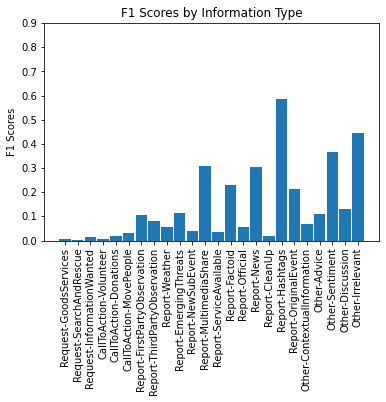

In [318]:
# --------------------------------------------------
# TREC-IS 2019-A
# Information Type Categorization
# Per Information Type F1 Graph
# --------------------------------------------------
# Per Category Classification Performance
# F1 scores for each information type, graphed
# Does not average across events (larger events have more impact)



N = len(informationTypes2Index)
ind = np.arange(N)

scoresPerCategoryF1 = []
categoryLabels = []
for categoryId in informationTypes2Index.keys():
    scoresPerCategoryF1.append(f1_score(category2GroundTruth[categoryId], category2Predicted[categoryId], average='binary'))
    categoryLabels.append(categoryId)
    
width = 0.90       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, scoresPerCategoryF1, width)

plt.ylabel('F1 Scores')
plt.title('F1 Scores by Information Type')
plt.xticks(ind, categoryLabels, rotation='vertical')
plt.yticks(np.arange(0, 1, 0.1))

plt.show()

In [319]:
# --------------------------------------------------
# TREC-IS 2019-A
# Information Type Categorization
# Per Event Performance
# --------------------------------------------------
# Categorization performance for each event
# Precision, recall and F1 only consider the positive class
# Accuracy is an overall metric
# We report performance for all categories, high importance categories and low importance categories
# Macro average (categories have equal weight)

perEventFile.write("--------------------------------------------------"+"\n")
perEventFile.write("EVALUATON: Information Type Categorization (Multi-type)"+"\n")
perEventFile.write("Per Event Performance"+"\n")
perEventFile.write("--------------------------------------------------"+"\n")

for eventId in eventIdentifiers:
    avgPrecision = 0.0
    avgRecall = 0.0
    avgF1 = 0.0
    avgAccuracy = 0.0
    
    avgPrecisionHigh = 0.0
    avgRecallHigh = 0.0
    avgF1High = 0.0
    avgAccuracyHigh = 0.0

    avgPrecisionLow = 0.0
    avgRecallLow = 0.0
    avgF1Low = 0.0
    avgAccuracyLow = 0.0

    for categoryId in informationTypes2Index.keys():
        
        categoryPrecision = precision_score(event2groundtruth[eventId].get(categoryId), event2prediction[eventId].get(categoryId), average='binary')
        categoryRecall = recall_score(event2groundtruth[eventId].get(categoryId), event2prediction[eventId].get(categoryId), average='binary')
        categoryF1 = f1_score(event2groundtruth[eventId].get(categoryId), event2prediction[eventId].get(categoryId), average='binary')
        categoryAccuracy = accuracy_score(event2groundtruth[eventId].get(categoryId), event2prediction[eventId].get(categoryId))
        
        avgPrecision = avgPrecision + categoryPrecision
        avgRecall = avgRecall + categoryRecall
        avgF1 = avgF1 + categoryF1
        avgAccuracy = avgAccuracy + categoryAccuracy
        
        if any(categoryId in s for s in highImportCategories):
            avgPrecisionHigh = avgPrecisionHigh + categoryPrecision
            avgRecallHigh = avgRecallHigh + categoryRecall
            avgF1High = avgF1High + categoryF1
            avgAccuracyHigh = avgAccuracyHigh + categoryAccuracy
        else:
            avgPrecisionLow = avgPrecisionLow + categoryPrecision
            avgRecallLow = avgRecallLow + categoryRecall
            avgF1Low = avgF1Low + categoryF1
            avgAccuracyLow = avgAccuracyLow + categoryAccuracy
        
    print(eventId)
    print("  Information Type Precision (positive class, multi-type, macro): "+str(avgPrecision/len(informationTypes2Index)))
    print("  Information Type Recall (positive class, multi-type, macro): "+str(avgRecall/len(informationTypes2Index)))
    print("  Information Type F1 (positive class, multi-type, macro): "+str(avgF1/len(informationTypes2Index)))
    print("  Information Type Accuracy (overall, multi-type, macro): "+str(avgAccuracy/len(informationTypes2Index)))
    print("  High Importance Information Type Precision (positive class, multi-type, macro): "+str(avgPrecisionHigh/numHighInformationTypes))
    print("  High Importance Information Type Recall (positive class, multi-type, macro): "+str(avgRecallHigh/numHighInformationTypes))
    print("  High Importance Information Type F1 (positive class, multi-type, macro): "+str(avgF1High/numHighInformationTypes))
    print("  High Importance Information Type Accuracy (overall, multi-type, macro): "+str(avgAccuracyHigh/numHighInformationTypes))
    print("  Low Importance Information Type Precision (positive class, multi-type, macro): "+str(avgPrecisionLow/numLowInformationTypes))
    print("  Low Importance Information Type Recall (positive class, multi-type, macro): "+str(avgRecallLow/numLowInformationTypes))
    print("  Low Importance Information Type F1 (positive class, multi-type, macro): "+str(avgF1Low/numLowInformationTypes))
    print("  Low Importance Information Type Accuracy (overall, multi-type, macro): "+str(avgAccuracyLow/numLowInformationTypes))
    print("")
    
    perEventFile.write(eventId+"\n")
    perEventFile.write("  Information Type Precision (positive class, multi-type, macro): "+str(avgPrecision/len(informationTypes2Index))+"\n")
    perEventFile.write("  Information Type Recall (positive class, multi-type, macro): "+str(avgRecall/len(informationTypes2Index))+"\n")
    perEventFile.write("  Information Type F1 (positive class, multi-type, macro): "+str(avgF1/len(informationTypes2Index))+"\n")
    perEventFile.write("  Information Type Accuracy (overall, multi-type, macro): "+str(avgAccuracy/len(informationTypes2Index))+"\n")
    perEventFile.write("  High Importance Information Type Precision (positive class, multi-type, macro): "+str(avgPrecisionHigh/numHighInformationTypes)+"\n")
    perEventFile.write("  High Importance Information Type Recall (positive class, multi-type, macro): "+str(avgRecallHigh/numHighInformationTypes)+"\n")
    perEventFile.write("  High Importance Information Type F1 (positive class, multi-type, macro): "+str(avgF1High/numHighInformationTypes)+"\n")
    perEventFile.write("  High Importance Information Type Accuracy (overall, multi-type, macro): "+str(avgAccuracyHigh/numHighInformationTypes)+"\n")
    perEventFile.write("  Low Importance Information Type Precision (positive class, multi-type, macro): "+str(avgPrecisionLow/numLowInformationTypes)+"\n")
    perEventFile.write("  Low Importance Information Type Recall (positive class, multi-type, macro): "+str(avgRecallLow/numLowInformationTypes)+"\n")
    perEventFile.write("  Low Importance Information Type F1 (positive class, multi-type, macro): "+str(avgF1Low/numLowInformationTypes)+"\n")
    perEventFile.write("  Low Importance Information Type Accuracy (overall, multi-type, macro): "+str(avgAccuracyLow/numLowInformationTypes)+"\n")
    perEventFile.write("\n")
    
perEventFile.write("\n")

floodChoco2019
  Information Type Precision (positive class, multi-type, macro): 0.04620744366580195
  Information Type Recall (positive class, multi-type, macro): 0.23106060606060605
  Information Type F1 (positive class, multi-type, macro): 0.0529921699084879
  Information Type Accuracy (overall, multi-type, macro): 0.46133247643530423
  High Importance Information Type Precision (positive class, multi-type, macro): 0.00228310502283105
  High Importance Information Type Recall (positive class, multi-type, macro): 0.2222222222222222
  High Importance Information Type F1 (positive class, multi-type, macro): 0.004478114478114478
  High Importance Information Type Accuracy (overall, multi-type, macro): 0.448586118251928
  Low Importance Information Type Precision (positive class, multi-type, macro): 0.06084888988012557
  Low Importance Information Type Recall (positive class, multi-type, macro): 0.23400673400673405
  Low Importance Information Type F1 (positive class, multi-type, macro):

1

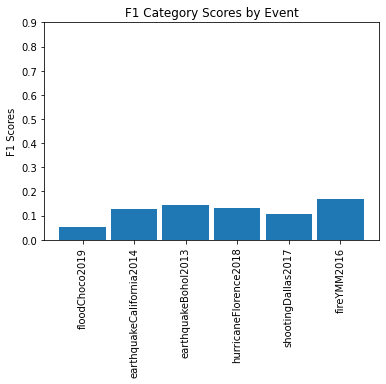

In [320]:
# --------------------------------------------------
# TREC-IS 2019-A
# Information Type Categorization
# Per Event F1 Graph
# --------------------------------------------------
# Multi-type (1 vs All): Tweets have multiple information types, aim: predict all of them
# Macro average (categories have equal weight)

N = len(eventIdentifiers)
ind = np.arange(N)

scoresPerEventF1 = []
for eventId in eventIdentifiers:
    avgF1 = 0.0

    for categoryId in informationTypes2Index.keys():
        avgF1 = avgF1 + f1_score(event2groundtruth[eventId].get(categoryId), event2prediction[eventId].get(categoryId), average='binary')
        
    scoresPerEventF1.append(avgF1/len(informationTypes2Index))
    
width = 0.90       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, scoresPerEventF1, width)

plt.ylabel('F1 Scores')
plt.title('F1 Category Scores by Event')
plt.xticks(ind, eventIdentifiers, rotation='vertical')
plt.yticks(np.arange(0, 1, 0.1))

plt.show()

In [321]:
# --------------------------------------------------
# TREC-IS 2019-A
# Information Priority Level
# Overall Performance
# --------------------------------------------------
# How divergent is the system from the human priority labels?
# Converts the human labels into numerical values, see priorityMapping
# Average error over information types, lower is better
# Macro average (categories have equal weight)

from sklearn.metrics import mean_squared_error

avgMSE = 0.0;
avgMSEHigh = 0.0;
avgMSELow = 0.0;
for categoryId in informationTypes2Index.keys():
    groundTruthPriorities = category2GroundTruthPriority[categoryId]
    predictedPriorities = category2PredictedPriority[categoryId]
    
    error = mean_squared_error(groundTruthPriorities, predictedPriorities)
    avgMSE = avgMSE + error;
    
    if any(categoryId in s for s in highImportCategories):
        avgMSEHigh = avgMSEHigh + error
    else:
        avgMSELow = avgMSELow + error
    
    
    
print("Priority Estimation Error (mean squared error, macro): "+str(avgMSE/len(informationTypes2Index)))
print("Priority Estimation Error High Importance (mean squared error, macro): "+str(avgMSEHigh/numHighInformationTypes))
print("Priority Estimation Error Low Importance (mean squared error, macro): "+str(avgMSELow/numLowInformationTypes))
    
resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("EVALUATON: Information Priority Level"+"\n")
resultsFile.write("Overall Performance"+"\n")
resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("> Priority Estimation Error (mean squared error, macro): "+str(avgMSE/len(informationTypes2Index))+"\n")
resultsFile.write("> Priority Estimation Error High Importance (mean squared error, macro): "+str(avgMSEHigh/numHighInformationTypes)+"\n")
resultsFile.write("> Priority Estimation Error Low Importance (mean squared error, macro): "+str(avgMSELow/numLowInformationTypes)+"\n")
resultsFile.write("\n")

Priority Estimation Error (mean squared error, macro): 0.0783969475473129
Priority Estimation Error High Importance (mean squared error, macro): 0.19083250312933886
Priority Estimation Error Low Importance (mean squared error, macro): 0.04091842901997088


1

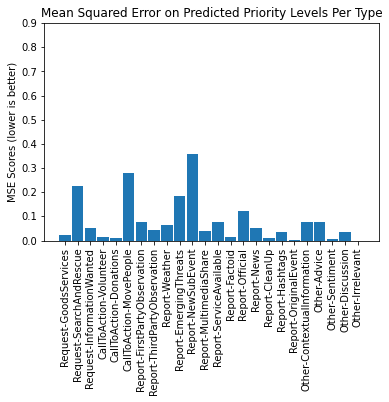

In [322]:
# --------------------------------------------------
# TREC-IS 2019-A
# Information Priority Level
# Per Information Type Performance
# --------------------------------------------------
# Error per information type, lower is better

N = len(informationTypes2Index)
ind = np.arange(N)

mseValues = []
categoryLabels = []
for categoryId in informationTypes2Index.keys():
    groundTruthPriorities = category2GroundTruthPriority[categoryId]
    predictedPriorities = category2PredictedPriority[categoryId]
    error = mean_squared_error(groundTruthPriorities, predictedPriorities)
    categoryLabels.append(categoryId)
    mseValues.append(error);
    
width = 0.90       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, mseValues, width)

plt.ylabel('MSE Scores (lower is better)')
plt.title('Mean Squared Error on Predicted Priority Levels Per Type')
plt.xticks(ind, categoryLabels, rotation='vertical')
plt.yticks(np.arange(0, 1, 0.1))

plt.show()

In [323]:
# Print the evaluation table row in latex
print("Run & AW-H & AW-A & CF1-H & CF1-A & CAcc & PErr-H & PErr-A \\\\")

resultLine = (str.format('{0:.4f}', totalHighImportWorth)+
     " & "+
     str.format('{0:.4f}', AccumulatedAlertWorth)+
     " & "+
     str.format('{0:.4f}',avgF1High/numHighInformationTypes)+
     " & "+
     str.format('{0:.4f}',avgF1/numInformationTypes)+
     " & "+
     str.format('{0:.4f}',avgAccuracy/numInformationTypes)+
     " & "+
     str.format('{0:.4f}',avgMSEHigh/numHighInformationTypes)+
     " & "+
     str.format('{0:.4f}',avgMSE/len(informationTypes2Index))+
     " \\\\")

print(runName+" & "+resultLine)

resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("LATEX"+"\n")
resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write(runName+" & "+resultLine)

Run & AW-H & AW-A & CF1-H & CF1-A & CAcc & PErr-H & PErr-A \\
myrun & -0.7061 & -0.3530 & 0.0773 & 0.1706 & 0.3389 & 0.1908 & 0.0784 \\


73

In [324]:
# Done
resultsFile.close() 
perTopicFile.close()
perEventFile.close()